In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

### 附件1的读取

In [331]:
df1_1 = pd.read_excel("附件1：123家有信贷记录企业的相关数据.xlsx", sheet_name="企业信息")
df1_2 = pd.read_excel("附件1：123家有信贷记录企业的相关数据.xlsx", sheet_name="进项发票信息")
df1_3 = pd.read_excel("附件1：123家有信贷记录企业的相关数据.xlsx", sheet_name="销项发票信息")

### 将对应信息整合到一个表

In [332]:
id_to = list(df1_1["企业代号"])
id0 = []
id0_degree = []
id1 = []
id1_degree = []
for i in id_to:
    # 获取总次数
    df1_31 = df1_3[df1_3["企业代号"]==i]
    total = df1_31.count()[0]
    ok_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]>=0)].count()[0] / total
    fu_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]<0)].count()[0] / total
    not_num = df1_31[df1_31["发票状态"]=="作废发票"].count()[0] / total
    money_avg = df1_31[df1_31["金额"]>=0]["金额"].sum() / total
    not_num1 = df1_31[(df1_31["发票状态"]=="作废发票") & (df1_31["金额"]==0)].count()[0] / total 
    degree = list(df1_1[df1_1["企业代号"]==i]["信誉评级"])
    if not_num1 > 0.05:
        id0.append(i)
        id0_degree.extend(degree)
    else:
        id1.append(i)
        id1_degree.extend(degree)

In [333]:
# 获取企业代号
def new_data(id0, name):
    # 每个企业对应的进项发票各类状态占比
    in_ok = []  # 有效占比
    in_fu = []  # 负数占比
    in_not = []  # 作废占比
    in_count = []  # 次数
    in_money = []  # 金额/次
    for i in id0:
        # 获取总次数
        df1_21 = df1_2[df1_2["企业代号"]==i]
        total = df1_21.count()[0]
        ok_num = df1_21[(df1_21["发票状态"]=="有效发票") & (df1_21["金额"]>=0)].count()[0] / total
        fu_num = df1_21[(df1_21["发票状态"]=="有效发票") & (df1_21["金额"]<0)].count()[0] / total
        not_num = df1_21[df1_21["发票状态"]=="作废发票"].count()[0] / total
        money_avg = df1_21[df1_21["金额"]>=0]["金额"].sum() / total
        in_ok.append(ok_num)
        in_fu.append(fu_num)
        in_not.append(not_num)
        in_count.append(total)
        in_money.append(money_avg)

    # 每个企业对应的销项发票各类状态占比
    out_ok = []  # 有效占比
    out_fu = []  # 负数占比
    out_not = []  # 作废占比
    out_count = []  # 次数
    out_money = []  # 金额
    for i in id0:
        # 获取总次数
        df1_31 = df1_3[df1_3["企业代号"]==i]
        total = df1_31.count()[0]
        ok_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]>=0)].count()[0] / total
        fu_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]<0)].count()[0] / total
        not_num = df1_31[df1_31["发票状态"]=="作废发票"].count()[0] / total
        money_avg = df1_31[df1_31["金额"]>=0]["金额"].sum() / total
        out_ok.append(ok_num)
        out_fu.append(fu_num)
        out_not.append(not_num)
        out_count.append(total)
        out_money.append(money_avg)

    df_new = pd.DataFrame({"企业代号": id0, "进项有效发票占比": in_ok, "进项作废发票占比": in_not, "进项负数发票占比": in_fu, "进项次数": in_count, "进项平均每次金额": in_money, "销项有效发票占比": out_ok, "销项作废发票占比": out_not, "销项负数发票占比": out_fu, "销项次数": out_count, "销项平均每次金额": out_money})
    df_new.to_csv(f"{name}.csv", index=False, sep=",")

In [334]:
new_data(id0, "整合数据1")
new_data(id1, "整合数据2")

## 主成分分析

In [353]:
def mein(data):
    data1 = np.array(data)
    data_new = []
    for i in data1:
        data_new.append(list(np.delete(i, 0)))
    data_new = np.array(data_new)

    # 对每一个属性的样本求均值
    MEAN = np.mean(data_new, axis=0)

    # 去中心化
    X = np.subtract(data_new, MEAN)

    # 计算协方差矩阵
    COV = np.dot(X.T, X)

    # 计算特征值和特征向量
    W, V = np.linalg.eig(COV)  # W特征值，V特征向量

    # 计算主成分贡献率以及累计贡献率
    sum_lambda = np.sum(W) # 特征值的和


    f = np.divide(W, sum_lambda) # 每个特征值的贡献率（特征值 / 总和)
    print(f)

    # 前两大特征值对应的特征向量为：
    e1 = V.T[0]
    e2 = V.T[1]
    print(e1)
    print(e2)


    # 计算主成分值（已去中心化）
    z1 = np.dot(X, e1)
    z2 = np.dot(X, e2)

    # 输出降维后的结果（已去中心化）
    RES = np.array([z1,z2])

    return RES.T


## 判别分析（距离）

In [354]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# 得到初始数据
data = pd.read_csv("整合数据2.csv")

x0 = np.array(mein(data))

# 处理马氏 44
target = id1_degree

v=np.cov(x0.T) #计算协方差

knn = KNeighborsClassifier(4, metric='mahalanobis', metric_params={'V': v}) #马氏距离分类

knn.fit(x0,target)

pre=knn.predict(x0)
print("马氏距离分类结果: ",pre)
print("误差率:", 1-knn.score(x0, target))

[ 7.26372224e-01  2.73205910e-01  3.47266277e-04  7.45996069e-05
  2.28850007e-13  2.81538237e-14  3.55141561e-14  2.19878489e-15
 -6.23444333e-19  4.05081714e-27]
[-3.81976810e-08  3.08289423e-08  7.36873874e-09  1.35000222e-03
  8.33231001e-01  4.16157259e-08 -3.65684690e-08 -5.04725691e-09
  2.30658470e-03  5.52918580e-01]
[ 1.68895929e-08 -1.76848444e-08  7.95251055e-10 -3.61856870e-03
  5.52911247e-01  3.80390927e-08 -3.66473463e-08 -1.39174638e-09
  3.40725299e-03 -8.33225329e-01]
马氏距离分类结果:  ['C' 'A' 'A' 'B' 'B' 'A' 'A' 'A' 'C' 'A' 'C' 'A' 'C' 'A' 'A' 'A' 'A' 'B'
 'B' 'A' 'A' 'B' 'A' 'A' 'A' 'A' 'A' 'C' 'A' 'A' 'B' 'B' 'A' 'B' 'B' 'C'
 'C' 'A' 'A' 'C' 'A' 'C' 'C' 'A' 'C' 'C' 'B' 'D' 'C' 'B' 'C' 'A' 'B' 'A'
 'C' 'C' 'A' 'A' 'D' 'B' 'A' 'A' 'B' 'B' 'B' 'B' 'D' 'B' 'C' 'B' 'B' 'C'
 'D' 'A' 'B' 'A' 'B' 'A' 'A' 'A' 'A' 'A' 'C' 'B' 'A' 'B' 'B' 'B' 'B' 'C'
 'D' 'B' 'B' 'D' 'C' 'B' 'D' 'B' 'B' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'B']
误差率: 0.3738317757009346


In [355]:
data1 = pd.read_csv("整合数据1.csv")
x01 = np.array(mein(data1))

target1 = id0_degree

v1=np.cov(x01.T) #计算协方差

knn1 = KNeighborsClassifier(4) #欧氏距离分类

knn1.fit(x01,target1)

pre1=knn1.predict(x01)

print("欧氏距离分类结果: ",pre1)

print("误差率:", 1-knn1.score(x01, target1))

[ 8.99119488e-01  9.32956944e-02  7.56020967e-03  2.46082156e-05
  1.52900135e-11  1.16526031e-12  2.31244848e-13  2.64381165e-14
 -1.78395698e-19  2.17467264e-26]
[ 5.43191500e-07 -4.93658024e-07 -4.95334756e-08 -1.20009672e-02
 -2.41228191e-01 -1.38794306e-06  1.39462755e-06 -6.68448920e-09
 -2.51852295e-03 -9.70390949e-01]
[ 8.36330090e-09 -6.88792387e-09 -1.47537720e-09  7.14694840e-02
 -9.67989421e-01 -1.13188432e-06  6.59517348e-07  4.72366977e-07
  2.08755717e-02  2.39693145e-01]
欧氏距离分类结果:  ['C' 'C' 'B' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'C' 'D' 'D' 'D' 'D' 'D']
误差率: 0.25


In [338]:
list1 = [[int(i[1:]), j] for i, j in zip(id0, pre1)] 
list2 = [[int(i[1:]), j] for i, j in zip(id1, pre)]
list1.extend(list2)
list1.sort()
value = [i[1] for i in list1]
df1_1.insert(3, column="判别归类", value=value)
df1_1.to_csv("原本评级和判别评级对比表.csv", index=False)

## 第二问

In [339]:
df2_1 = pd.read_excel("附件2：302家无信贷记录企业的相关数据.xlsx", sheet_name="企业信息")
df2_2 = pd.read_excel("附件2：302家无信贷记录企业的相关数据.xlsx", sheet_name="进项发票信息")
df2_3 = pd.read_excel("附件2：302家无信贷记录企业的相关数据.xlsx", sheet_name="销项发票信息")

In [340]:
id_to = list(df2_1["企业代号"])
id0 = []
id1 = []
for i in id_to:
    # 获取总次数
    df1_31 = df2_3[df2_3["企业代号"]==i]
    total = df1_31.count()[0]
    ok_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]>=0)].count()[0] / total
    fu_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]<0)].count()[0] / total
    not_num = df1_31[df1_31["发票状态"]=="作废发票"].count()[0] / total
    money_avg = df1_31[df1_31["金额"]>=0]["金额"].sum() / total
    not_num1 = df1_31[(df1_31["发票状态"]=="作废发票") & (df1_31["金额"]==0)].count()[0] / total 
    if not_num1 > 0.05:
        id0.append(i)
    else:
        id1.append(i)


In [341]:
# 获取企业代号
def new_data(id0, name):
    # 每个企业对应的进项发票各类状态占比
    in_ok = []  # 有效占比
    in_fu = []  # 负数占比
    in_not = []  # 作废占比
    in_count = []  # 次数
    in_money = []  # 金额/次
    for i in id0:
        # 获取总次数
        df1_21 = df2_2[df2_2["企业代号"]==i]
        total = df1_21.count()[0]
        ok_num = df1_21[(df1_21["发票状态"]=="有效发票") & (df1_21["金额"]>=0)].count()[0] / total
        fu_num = df1_21[(df1_21["发票状态"]=="有效发票") & (df1_21["金额"]<0)].count()[0] / total
        not_num = df1_21[df1_21["发票状态"]=="作废发票"].count()[0] / total
        money_avg = df1_21[df1_21["金额"]>=0]["金额"].sum() / total
        in_ok.append(ok_num)
        in_fu.append(fu_num)
        in_not.append(not_num)
        in_count.append(total)
        in_money.append(money_avg)

    # 每个企业对应的销项发票各类状态占比
    out_ok = []  # 有效占比
    out_fu = []  # 负数占比
    out_not = []  # 作废占比
    out_count = []  # 次数
    out_money = []  # 金额
    for i in id0:
        # 获取总次数
        df1_31 = df2_3[df2_3["企业代号"]==i]
        total = df1_31.count()[0]
        ok_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]>=0)].count()[0] / total
        fu_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]<0)].count()[0] / total
        not_num = df1_31[df1_31["发票状态"]=="作废发票"].count()[0] / total
        money_avg = df1_31[df1_31["金额"]>=0]["金额"].sum() / total
        out_ok.append(ok_num)
        out_fu.append(fu_num)
        out_not.append(not_num)
        out_count.append(total)
        out_money.append(money_avg)

    df_new = pd.DataFrame({"企业代号": id0, "进项有效发票占比": in_ok, "进项作废发票占比": in_not, "进项负数发票占比": in_fu, "进项次数": in_count, "进项平均每次金额": in_money, "销项有效发票占比": out_ok, "销项作废发票占比": out_not, "销项负数发票占比": out_fu, "销项次数": out_count, "销项平均每次金额": out_money})
    df_new.to_csv(f"{name}.csv", index=False, sep=",")

In [342]:
new_data(id0, "整合数据3") # 这个是二类  knn1
new_data(id1, "整合数据4")

In [343]:
data1 = pd.read_csv("整合数据3.csv")
x01 = np.array(mein(data1))

pre1=knn1.predict(x01)

print("欧氏距离分类结果: ",pre1)

欧氏距离分类结果:  ['B' 'C' 'C' 'C' 'C' 'D' 'C' 'C' 'C' 'D' 'C' 'D' 'C' 'D' 'D' 'C' 'C' 'D'
 'D' 'D']


In [344]:
data = pd.read_csv("整合数据4.csv")
x1 = np.array(mein(data))

pre=knn.predict(x1)

print("欧氏距离分类结果: ",pre)

欧氏距离分类结果:  ['B' 'B' 'A' 'B' 'B' 'C' 'A' 'A' 'B' 'B' 'C' 'B' 'C' 'B' 'B' 'C' 'B' 'C'
 'C' 'A' 'B' 'C' 'A' 'A' 'B' 'B' 'B' 'B' 'A' 'B' 'A' 'C' 'B' 'A' 'B' 'B'
 'A' 'B' 'B' 'B' 'A' 'C' 'A' 'C' 'B' 'A' 'A' 'C' 'C' 'C' 'A' 'C' 'B' 'B'
 'A' 'A' 'A' 'C' 'C' 'B' 'A' 'C' 'A' 'B' 'C' 'A' 'B' 'A' 'A' 'C' 'D' 'C'
 'C' 'A' 'B' 'A' 'A' 'C' 'A' 'A' 'A' 'C' 'A' 'A' 'C' 'B' 'B' 'A' 'B' 'C'
 'B' 'B' 'A' 'A' 'A' 'C' 'A' 'A' 'C' 'C' 'B' 'A' 'A' 'B' 'B' 'B' 'B' 'B'
 'A' 'A' 'A' 'C' 'C' 'B' 'C' 'A' 'A' 'A' 'B' 'A' 'B' 'C' 'A' 'C' 'B' 'A'
 'A' 'A' 'C' 'C' 'B' 'A' 'C' 'C' 'A' 'C' 'B' 'C' 'B' 'B' 'C' 'B' 'B' 'A'
 'A' 'C' 'B' 'B' 'B' 'B' 'C' 'C' 'C' 'B' 'A' 'B' 'C' 'B' 'C' 'C' 'C' 'C'
 'B' 'A' 'B' 'A' 'C' 'C' 'A' 'B' 'A' 'C' 'B' 'A' 'C' 'A' 'C' 'B' 'C' 'C'
 'B' 'C' 'A' 'A' 'B' 'C' 'A' 'C' 'A' 'A' 'A' 'A' 'B' 'A' 'B' 'B' 'D' 'A'
 'A' 'B' 'C' 'B' 'C' 'B' 'C' 'B' 'C' 'A' 'D' 'A' 'B' 'C' 'D' 'B' 'C' 'A'
 'C' 'B' 'C' 'A' 'C' 'C' 'D' 'D' 'B' 'B' 'B' 'D' 'A' 'A' 'A' 'C' 'D' 'B'
 'D' 'C' 'C' 'D' 'C' 'C' 'D' 'D' 'A' 'D'

In [345]:
list1 = [[int(i[1:]), j] for i, j in zip(id0, pre1)] 
list2 = [[int(i[1:]), j] for i, j in zip(id1, pre)]
list1.extend(list2)
list1.sort()
value = [i[1] for i in list1]
df2_1.insert(2, column="判别归类", value=value)
df2_1.to_csv("判别评级表.csv", index=False)

In [244]:
# 基于XGBoost原生接口的分类
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score   # 准确率

mo = []
for i in target:
    if i == "A":
        mo.append(1)
    elif i == "B":
        mo.append(2)
    elif i == "C":
        mo.append(3)
    elif i == "D":
        mo.append(4)

x_data, y_data = data_new, mo
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 4,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}
plst = params.items()
dtrain = xgb.DMatrix(x_data, y_data)  # 生成数据集格式
model = xgb.train(params,
                  dtrain,  # 训练的数据
                  num_boost_round=500  # 提升迭代的个数
                  ) # xgboost模型训练
 
 
# 对测试集进行预测
dtest = xgb.DMatrix(x_data)
y_pred = model.predict(dtest)
print(y_pred)
# 计算准确率
accuracy = accuracy_score(y_data,y_pred)
print("accuarcy: %.2f%%" % (accuracy*100.0))
 
# 显示重要特征
# plot_importance(model)
# plt.show()

 
# # ================基于XGBoost原生接口的回归=============
 
# import xgboost as xgb
# from xgboost import plot_importance
# from matplotlib import pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_boston
# from sklearn.metrics import mean_squared_error
 
# # 加载数据集
# boston = load_boston()
# X,y = boston.data,boston.target
 
# # XGBoost训练过程
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
 
# params = {
#     'booster': 'gbtree',
#     'objective': 'reg:gamma',
#     'gamma': 0.1,
#     'max_depth': 5,
#     'lambda': 3,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 3,
#     'silent': 1,
#     'eta': 0.1,
#     'seed': 1000,
#     'nthread': 4,
# }
 
# dtrain = xgb.DMatrix(X_train, y_train)
# model = xgb.train(params, dtrain, num_boost_round=500)
 
# # 对测试集进行预测
# dtest = xgb.DMatrix(X_test)
# ans = model.predict(dtest)
 
# # 显示重要特征
# plot_importance(model)
# plt.show()
 
 
 
# # ==============基于Scikit-learn接口的分类================
# from sklearn.datasets import load_iris
# import xgboost as xgb
# from xgboost import plot_importance
# from matplotlib import pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
 
# # 加载样本数据集
# iris = load_iris()
# X,y = iris.data,iris.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234565) # 数据集分割
 
# # 训练模型
# model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='multi:softmax')
# model.fit(X_train, y_train)
 
# # 对测试集进行预测
# y_pred = model.predict(X_test)
 
# # 计算准确率
# accuracy = accuracy_score(y_test,y_pred)
# print("accuarcy: %.2f%%" % (accuracy*100.0))
 
# # 显示重要特征
# plot_importance(model)
# plt.show()
 
 
# # ================基于Scikit-learn接口的回归================
# import xgboost as xgb
# from xgboost import plot_importance
# from matplotlib import pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_boston
 
# boston = load_boston()
# X,y = boston.data,boston.target
 
# # XGBoost训练过程
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
 
# model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='reg:gamma')
# model.fit(X_train, y_train)
 
# # 对测试集进行预测
# ans = model.predict(X_test)
 
# # 显示重要特征
# plot_importance(model)
# plt.show()
 

XGBoostError: [17:31:21] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\data\data.cc:455: Check failed: this->labels.Size() % this->num_row_ == 0 (109 vs. 0) : Incorrect size for labels.

In [266]:
id_to = list(df1_1["企业代号"])
id = []
id1 = []
for i in id_to:
    # 获取总次数
    df1_31 = df1_3[df1_3["企业代号"]==i]
    total = df1_31.count()[0]
    ok_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]>=0)].count()[0] / total
    fu_num = df1_31[(df1_31["发票状态"]=="有效发票") & (df1_31["金额"]<0)].count()[0] / total
    not_num = df1_31[df1_31["发票状态"]=="作废发票"].count()[0] / total
    money_avg = df1_31[df1_31["金额"]>=0]["金额"].sum() / total
    not_num1 = df1_31[(df1_31["发票状态"]=="作废发票") & (df1_31["金额"]==0)].count()[0] / total 
    if not_num1 > 0.05:
        id.append(i)
    else:
        id1.append(i)

['E13', 'E32', 'E34', 'E40', 'E52', 'E53', 'E55', 'E72', 'E90', 'E102', 'E107', 'E111', 'E119', 'E120', 'E121', 'E123']


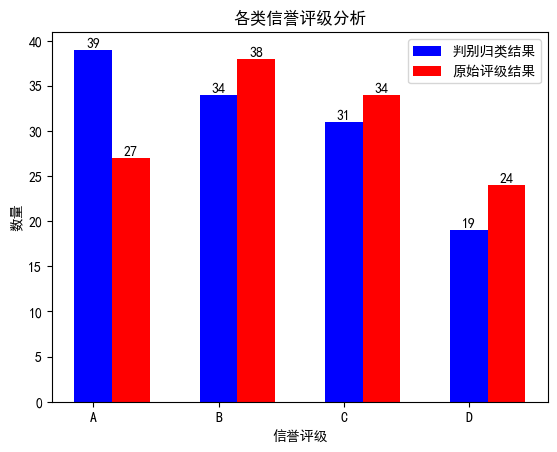

In [18]:
df = pd.read_csv("原本评级和判别评级对比表.csv")
 
x_data = ["A", "B", "C", "D"]
x_width = range(0, len(x_data))
x1_width = [i+0.3 for i in x_width]
y_data = [0, 0, 0, 0]
y_data1 = [0, 0, 0, 0]

for i in df["判别归类"]:
    if i == x_data[0]:
        y_data[0] += 1
    elif i == x_data[1]:
        y_data[1] += 1
    elif i == x_data[2]:
        y_data[2] += 1
    elif i == x_data[3]:
        y_data[3] += 1

for i in df["信誉评级"]:
    if i == x_data[0]:
        y_data1[0] += 1
    elif i == x_data[1]:
        y_data1[1] += 1
    elif i == x_data[2]:
        y_data1[2] += 1
    elif i == x_data[3]:
        y_data1[3] += 1        

plt.rcParams["font.sans-serif"]=['SimHei']
plt.rcParams["axes.unicode_minus"]=False
 

plt.bar(x_width,y_data, width=0.3, color="blue", label="判别归类结果")


plt.bar(x1_width,y_data1, width=0.3, color="red", label="原始评级结果")
    
    
for i,j in zip(x_width,y_data):
    plt.text(i,j+0.05,"%d"%j,ha="center",va="bottom")

for i,j in zip(x1_width,y_data1):
    plt.text(i,j+0.05,"%d"%j,ha="center",va="bottom")
    
plt.xticks(range(0, len(x_data)), x_data)
plt.legend()
plt.title("各类信誉评级分析")
plt.xlabel("信誉评级")
plt.ylabel("数量")
plt.savefig("2.png")
plt.show()
